In [5]:
### Allen B Davis
### Yale University
###
### First year project
### Summer 2015

# RVOS_Kepler will create RV observations of a star with one planet, create a periodogram with FAP,
# fit a Keplerian, and return uncertainities in the planet's mass and orbital parameters

In [6]:
# Imports
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
import pickle
from lmfit import minimize, Parameters, Parameter, report_fit
from time import strftime
import os
import errno

%matplotlib inline


plt.close()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
# Constants

### Constants, all in SI unless otherwise specified
mEarth = 5.97219E24
mJup = 1.898E27 
mSun = 1.9891E30 
G = 6.67384E-11
au = 149597870700. 
day = 86400.
year = 365.256363004*day
pi = math.pi
today = 2457129.53734 #JD

In [8]:
#Eventually make a Star class that calls Planet classes.

class Planet:
    
    def __init__(self,mass,period,massStar,ecc,incl,w,t0):
        
        self.mass = mass #in mEarth
        self.period = period #in years
        self.massStar = massStar #in mSun. Default: 1 solar mass
        self.ecc = ecc #eccentricity. Default: 0.2
        self.incl = incl #inclination in degrees. Default: 90.
        self.sini = np.sin(incl*pi/180.) #sin(i)
        
        def getSMA():
            totmass = (self.mass*mEarth)+(massStar*mSun)
            return (1/au) * ( ( (self.period*year)**2 * G*totmass ) / ( 4.*pi*pi))**(1./3.)
        
        self.sma = getSMA() #semimajor axis in AU. Given uniquely by mass, massStar, and period.
        
        if w==None:
            self.w = 2.*pi*np.random.random() #phase. default: random phase from [0,2pi)
        else:
            self.w = w
            
        self.t0 = t0 #JD of start. default: "today"
        self.tp = t0+(np.random.random()*period) #periastron time. Default: random from [today,today+period)   
        self.K = (2.*pi*G/(self.period*day))**(1./3.) * (self.mass*mEarth*self.sini) * ((self.massStar*mSun)**(-2./3.)) * (1./np.sqrt(1.-self.ecc**2.))
        #The above formula gives the correct value of K given Earth/Sun inputs. So VERIFIED.
        self.params = [self.period,self.ecc,self.tp,self.w,self.K,self.mass]
        self.params_print = [self.period,self.ecc,self.tp-self.t0,self.w*180./pi,self.K,self.mass]
        


In [9]:
# Will eventually handle multiple planets
def observe_star(planets,ndays,
                 offset_threshold=2./24.):
    #planets is an array of planets
    for p in planets:
        # Make all the random offsets first; we will draw from this list for each obs.
        roffsets = [np.random.random()*(2*offset_threshold) - (offset_threshold) for i in range(ndays)] 
        rnext = 0 #tracks the next element of the random list to pull from
        
        # Create the list of observation times according to the blind Doppler survey strategy
        obsList = np.arange(0,3) + roffsets[rnext:rnext+3]
        rnext = obsList.size
        
        if scatter(p,obsList+p.t0,False) > p.std_True: # Keep a separation of 1 day
            newtimes = np.arange(obsList.size,ndays)
            obsList = np.concatenate((obsList,newtimes+roffsets[rnext:ndays]))
            #print zip(np.arange(obsList.size),obsList),'\n'
        else: # Ramp it up to 5 day separation
            sep = 5 #separation in days b/w next obs
            n = 3 #how many more obs this round
            newtimes = np.arange(obsList.size-1+sep,obsList.size+n*sep,sep)
            obsList = np.concatenate((obsList,newtimes+roffsets[rnext:rnext+n]))
            rnext = obsList.size
            #print zip(np.arange(obsList.size),obsList),'\n'
            if scatter(p,obsList+p.t0 > p.std_True,False): # Keep a 5 day separation
                n = ndays - obsList.size + 1
                newtimes = np.arange(obsList[obsList.size-1]+sep,obsList[obsList.size-1]+n*sep,sep)
                obsList = np.concatenate((obsList,newtimes+roffsets[rnext:ndays]))
                #print zip(np.arange(obsList.size),obsList),'\n'
            else: # Ramp it up to 10 day separation and keep it there
                sep = 10
                n = ndays-obsList.size + 1
                newtimes = np.arange(obsList[obsList.size-1]+sep,obsList[obsList.size-1]+n*sep,sep)        
                obsList = np.concatenate((obsList,newtimes+roffsets[rnext:ndays]))
                #print zip(np.arange(obsList.size),obsList),'\n'
        
        # Set the JD
        p.obsList = obsList + p.t0
        
        #record true RV curve
        f = calcTrueAnomaly(p.period,p.tp,p.ecc,p.obsList)
        p.RV_True = p.K*(np.cos(p.w+f) + p.ecc*np.cos(p.w))
        
        #add jitter scaled to a normal distribution
        errList = np.random.normal(0, p.std_True, ndays)
        
        #record observed RV curve
        p.RV_Obs = p.RV_True + errList
        
        #record observated scatter in RV curve
        p.std_Obs = np.std(p.RV_Obs)

In [10]:
def scatter(p,obsList,lastThree):
        f = calcTrueAnomaly(p.period,p.tp,p.ecc,obsList)
        p.RV_True = p.K*(np.cos(p.w+f) + p.ecc*np.cos(p.w))
        if(lastThree):
            size = np.size(p.RV_True)
            return np.std(p.RV_True[size-3:size])
        else:
            return np.std(p.RV_True)


# Calculates the true anomaly from the time and orbital elements.
def calcTrueAnomaly(P, tp, e, t):

    phase = (t-tp)/P #phase at each obsList time
    M = 2.*pi*(phase - np.floor(phase)) #Mean Anom array: at each obsList time
    E1 = calcKepler(M, np.array([e]))

    n1 = 1. + e
    n2 = 1. - e

    #True Anomaly:
    return 2.*np.arctan(np.sqrt(n1/n2)*np.tan(E1/2.))


#returns Eccentric anomaly, given mean anomaly and eccentricity
def calcKepler(Marr_in, eccarr_in):


    nm = np.size(Marr_in)
    nec = np.size(eccarr_in)

    if nec == 1 and nm > 1:
        eccarr = eccarr_in #[eccarr_in for x in range(nm)]
    else:
        eccarr = eccarr_in

    if nec > 1 and nm == 1:
        Marr = Marr_in #[Marr_in for x in range(nec)]
    else:
        Marr = Marr_in

    conv = 1.E-12 #threshold for convergence
    k = 0.85 #some parameter for guessing ecc
    ssm = np.sign(np.sin(Marr))
    Earr = Marr+(ssm*k*eccarr)  #first guess at E
    fiarr = (Earr-(eccarr*np.sin(Earr))-Marr)  #E - e*sin(E)-M    ; should go to 0 when converges
    convd = np.where(abs(fiarr) > conv) #which indices are unconverged

    count = 0
    while np.size(convd) > 0:
        count += 1

        M = np.copy(Marr[convd]) #we only run the unconverged elements
        ecc = eccarr #[convd] ??
        E = np.copy(Earr[convd])
        fi = np.copy(fiarr[convd])

        fip = 1.-ecc*np.cos(E) #;d/dE(fi) ;i.e.,  fi^(prime)
        fipp = ecc*np.sin(E)  #;d/dE(d/dE(fi)) ;i.e.,  fi^(\prime\prime)
        fippp = 1.-fip #;d/dE(d/dE(d/dE(fi))) ;i.e.,  fi^(\prime\prime\prime)

        d1 = -fi/fip                             #;first order correction to E
        d2 = -fi/(fip+(d1*fipp/2.))                #;second order correction to E
        d3 = -fi/(fip+(d2*fipp/2.)+(d2*d2*fippp/6.)) #;third order correction to E

        E += d3 #apply correction to E

        #print np.size(Earr),np.size(E)
        Earr[convd] = E #update values

        fiarr = (Earr-eccarr*np.sin(Earr)-Marr)     #;how well did we do?
        convd = np.where(abs(fiarr) > conv)   #;test for convergence; update indices

        if count > 100:
#             print "WARNING!  Kepler's equation not solved!!!"
            break

    return Earr


def getMsini(pl):
    return 

In [11]:
### Solving orbit with LMfit

def solveOrbit(pl,P_G,periodList,obs_data,niter,guesses=None,flag=None):
        
    # define objective function: returns the array to be minimized
    def func(params, t, data):
        """ model decaying sine wave, subtract data"""
        P = params['P'].value
        e = params['e'].value
        tp = params['tp'].value
        h = params['h'].value
        c = params['c'].value
        v0 = params['v0'].value

        f = calcTrueAnomaly(P, tp, e, t)

        model = h*np.cos(f) + c*np.sin(f) + v0
        return model - data
    
    #initialize array of parameters
    params_array = [None]*niter
    result_array = [None]*niter
    chisq_array = [None]*niter
    
    #save some guesses that would otherwise be calculated many times
    p_guess = periodList[np.argmax(P_G)]
    
    # Do a bunch of fits
    for n in range(0,niter):
    
        # create a set of Parameters
        params = Parameters()
        params.add('P', value= p_guess, min=0)
        params.add('e', value= 0.05 + 0.7*np.random.random(), min=0)
        params.add('tp', value= pl.t0+(np.random.random()*p_guess))
        params.add('h', value= 4.*np.random.random()-2.) #prev guess 1
        params.add('c', value= 4.*np.random.random()-2.) #prev guess 1
        params.add('v0', value= 0.5*np.random.random()-0.25) #prev guess 0.1

        # do fit, here with leastsq model
        result = minimize(func, params, args=(pl.obsList, obs_data))
        
        # get chisq, which we will use to decide if this is the best fit
        chisq = np.sum(result.residual**2)
        
        # save params, result, and chisq
        params_array[n] = params
        result_array[n] = result
        chisq_array[n] = chisq
    
    # Continue, now using the best fit according to chisq
    n_best = np.argmin(chisq_array)
    params = params_array[n_best]
    result = result_array[n_best]
    
    # calculate final result
    final = obs_data + result.residual
    
    # write error report
#     report_fit(params)
    
    # Fitted params = [P,e,tp,h,c,v0]
    p_opt = params['P'].value
    e_opt = params['e'].value
    tp_opt = params['tp'].value #take the first periastron time in the interval for consistency
    
    w_opt = (np.arctan(-params['c'].value/params['h'].value))%(2.*pi) #[0-2pi) rads
    #The following corrects for the ambiguity in arctan. This condition is based on alternative
    #way to find K below. I multiply instead of divide because I just care about the sign,
    #and multiplication is probably faster than division.
    if params['v0'].value*e_opt*np.cos(w_opt) < 0:
        w_opt = (w_opt-pi)%(2.*pi)
    
    K_opt = np.sqrt(params['h'].value**2 + params['c'].value**2) #alternatively:
                                                                 #params['v0'].value/(e_opt*np.cos(w_opt))
                                                                 #but this allows negative amplitudes
    
    msini_fit = (1./mEarth) * (K_opt) * ((2.*pi*G/(p_opt*day))**(-1./3.)) * ((pl.massStar*mSun)**(2./3.)) * (np.sqrt(1-e_opt**2.))
    
    params_out = np.array([p_opt,e_opt,tp_opt,w_opt,K_opt,msini_fit])

    f_opt = calcTrueAnomaly(p_opt,tp_opt,e_opt,pl.obsList)
    RV_fit = K_opt*(np.cos(w_opt+f_opt) + e_opt*np.cos(w_opt))

    if "boot" == flag:
        return params_out
    else:
        pl.RV_fit = RV_fit
        pl.params_out = params_out
        pl.params_out_print = np.array([p_opt,e_opt,tp_opt-pl.t0,w_opt*180./pi,K_opt,msini_fit])
        pl.params_LMfit = params

In [12]:
# Determine FAP by drawing from the sampled velocities
def bootstrap_FAP(pl,freqList,niter):

    max_powers = [float]*niter #contains max power of each iteration

    RV_Obs_scram = np.copy(pl.RV_Obs) #initialize
    size = len(RV_Obs_scram)
    for n in range(0,niter):

        # Drawing randomly with replacement (bootstrap)
        for m in range(0,size):
            ind = size*np.random.random()
            RV_Obs_scram[m] = pl.RV_Obs[ind]

        # periodogram; max power
        P_G = sp.signal.lombscargle(pl.obsList, RV_Obs_scram, freqList)
        max_powers[n] = max(P_G)

    return np.sort(max_powers) #[lowest...highest]
    

# Returns the periodogram power corresponding to the given FAP (in percent)
def calc_FAP_power(powers,FAP):
    size = len(powers) #assumes sorted [lowest...highest]
    
    if FAP*size < 100:
        print 'WARNING: Too few iterations (%d) to accurately report FAP of %.2f%%' %(size,FAP)

    index = (size-1) - (size*FAP/100.)
    
    if index != int(index):
        print 'WARNING: Requested FAP (%.2f%%) has been approximated to a nearby percentile (%.2f%%)' %(FAP,size*int(index)/100)
        
    return powers[index] #this is a numpy array, so index m.n = index m

In [13]:
def bootstrap_Keplerian(pl,P_G,periodList,boot_niter,orbit_niter):
    size = np.size(pl.RV_fit)
    fit0 = np.copy(pl.RV_fit)
    data = np.copy(pl.RV_Obs)

    boot_params = [[float]*6]*boot_niter #stores each iteration's params: [P,e,tp,w,K,msini]
    
    #take the fit and subtract from the data
    resids = pl.RV_Obs - fit0
        
    for n in range(0,boot_niter):
        
        #randomly draw from the residuals and add them to the original fit
        new_resids = [resids[np.random.randint(0,size)] for _ in range(0,size)]
        new_data = fit0 + new_resids

        #fit this function and save the parameters    
        new_params = solveOrbit(pl,pl.P_G,periodList,new_data,orbit_niter,flag="boot")
        boot_params[n] = new_params

    return boot_params

In [14]:
class Simulator:
    def __init__(self,nobs,sigma,
                 jitter=0.0,massStar=1.0,massPlanet=5.0, period=15.,
                 ecc=0.2,incl=90.,w=None,t0=today,
                 pmin=0.1,pmax=500.,pres=0.01,
                 find_FAP=True,FAP_levels=[1,5],threshold_FAP=1.0,FAP_niter=100,
                 orbit_niter=100,boot_niter=1000,find_uncs=True):

        self.nobs = nobs
        self.sigma = sigma
        self.std_True = np.sqrt(sigma**2 + jitter**2)
        self.periodList = np.linspace(pmin,pmax,num=pmax/pres)
        self.freqList = 2.* pi / self.periodList
        
        self.find_FAP = find_FAP
        self.FAP_levels = FAP_levels
        self.FAP_niter = FAP_niter
        
        self.find_uncs = find_uncs
        self.boot_niter = boot_niter
        
        ###### Run simulation
        
        # Create a planet object with given astrophysical parameters
        p = Planet(massPlanet,period,massStar,ecc,incl,w,t0)
        
        # Create observations according to blind survey strategy
        p.std_True = self.std_True
        observe_star([p],nobs)

        # Make a LS periodogram of the observations
        p.P_G = sp.signal.lombscargle(p.obsList, p.RV_Obs,self.freqList)
        
        # Fit Keplerian to determine orbital parameters
        solveOrbit(p,p.P_G,self.periodList,p.RV_Obs,orbit_niter)
        
        # Find FAP levels by bootstrapping
        if self.find_FAP:
            max_powers_sort = bootstrap_FAP(p,self.freqList,FAP_niter)

            p.FAP_powers = [[float]*2]*len(FAP_levels) #set of ordered pairs: [[FAP lvl, power],...]
            for n in range(0,len(p.FAP_powers)):
                lvl = FAP_levels[n]
                power = calc_FAP_power(max_powers_sort,lvl)
                p.FAP_powers[n] = lvl,power
        
        # Calculate uncertainties in fitted parameters
        if self.find_uncs:
            p.boot_params = bootstrap_Keplerian(p,p.P_G,self.periodList,boot_niter,orbit_niter)
            p.uncs = np.std(p.boot_params,axis=0) #w in radians
        
        # Print and return planet's parameters
        inj_str = ("\nInjected parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
                  "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg"
                  "\nSemiamplitude = {4:.2f} m/s\nMass = {5:.2f} M_e").format(*p.params_print)
        fit_str = ("\nFitted parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
                  "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg"
                  "\nSemiamplitude = {4:.2f} m/s\nMsini = {5:.2f} M_e").format(*p.params_out_print)
        
        print inj_str
        print fit_str
        
        if self.find_uncs:
            unc_str = ("\n1-sigma uncertainities:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
                      "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg"
                      "\nSemiamplitude = {4:.2f} m/s\nMsini = {5:.2f} M_e").format(*p.uncs)
            print unc_str
            
        # Save planet(s)
        self.planet = p

In [19]:
def makePlot(sim,numpoints=500,fill=True,save='',fmt='png',hide_True=False):
    
    p = sim.planet
        
    if fill:
        # get more data points for nicer plotting
        start,end = p.obsList[0],p.obsList[-1]
        if numpoints == -1:
            #default is 10 points per period
            numpoints = int(np.round(10*(end-start)/p.period))

        times = np.linspace(start,end,numpoints)

        if not hide_True:
            f_True = calcTrueAnomaly(p.period,p.tp,p.ecc,times)
            RV_True = p.K*(np.cos(p.w+f_True) + p.ecc*np.cos(p.w))

        f_fit = calcTrueAnomaly(p.params_LMfit['P'].value,p.params_LMfit['tp'].value,p.params_LMfit['e'].value,times)
        RV_fit = p.params_out[4]*(np.cos(p.params_out[3]+f_fit) + p.params_out[1]*np.cos(p.params_out[3]))
    
    # Figure parameters
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    #Plot the RV curve
    plt.subplot(2, 1, 1)

    plt.plot(p.obsList, p.RV_Obs,'kx')
    
    if fill:
        plt.plot(times, RV_fit, 'b--',label='Fit')
        if not hide_True: plt.plot(times, RV_True,'r--',label='True')
    else:
        plt.plot(p.obsList, p.RV_fit,'b-',label='Fit')
        if not hide_True: plt.plot(p.obsList, p.RV_True,'r--',label='True')

#     plt.errorbar(p.obsList, p.RV_Obs, yerr=p.std_True, capsize=0,linestyle = 'none',ecolor='k')
    plt.xlabel('Time (days)')
    plt.ylabel('RV (m/s)')
    plt.xlim(p.obsList[0],p.obsList[-1])
#     plt.title(r'Period = %.2f days, Mass = %.1f mEarth' % (p.period,(p.mass)))
    
    if sim.find_uncs:
        title_str = (r'$M_{star}$=%.2f $M_{\odot}$, $N_{obs}$=%d, $\sigma_{RV}$=%.2f m/s'
                     '\nTrue: per=%.4f days, mass=%.2f $M_{\oplus}$, ecc=%.2f, w=%.2f deg'
                     '\nFit: per=%.4f$\pm$%.4f days, msini=%.2f$\pm$%.2f $M_{\oplus}$,'
                     'ecc=%.2f$\pm$%.2f, w=%.2f$\pm$%.2f deg'
                     '')%(p.massStar,sim.nobs,sim.sigma,
                          p.period,p.mass,p.ecc,p.w*180./pi,
                          p.params_out_print[0],p.uncs[0],p.params_out_print[5],p.uncs[5],
                          p.params_out_print[1],p.uncs[1],p.params_out_print[3],p.uncs[3]*180./pi)
    else:
        title_str = (r'$M_{star}$=%.2f $M_{\odot}$, $N_{obs}$=%d, $\sigma_{RV}$=%.2f m/s'
                     '\nTrue: per=%.4f days, mass=%.2f $M_{\oplus}$, ecc=%.2f, w=%.2f deg'
                     '\nFit: per=%.4f days, msini=%.2f $M_{\oplus}$, ecc=%.2f, w=%.2f deg'
                     '')%(p.massStar,sim.nobs,sim.sigma,
                          p.period,p.mass,p.ecc,p.w*180./pi,
                          p.params_out_print[0],p.params_out_print[5],
                          p.params_out_print[1],p.params_out_print[3])
        
    plt.title(title_str,fontsize=12)
    plt.legend(fontsize=10)
    
    #Plot the Periodogram
    plt.subplot(2, 1, 2)

    plt.plot(sim.periodList, p.P_G, 'k-')

    # plot the significance lines
    if sim.find_FAP:
        xlim = (np.min(sim.periodList), np.max(sim.periodList))
        for pair in p.FAP_powers:
            lvl,power = pair
            plt.plot(xlim,[power,power],'--', lw=1., label='%.2f%%'%lvl)
    
#     plt.xlim(sim.freqList[0],sim.freqList[-1])
    
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.xscale('log')
#     plt.title('Ntrials = %d' %sim.FAP_niter, fontsize=12)
    plt.tight_layout()
    plt.legend(fontsize=11)
    
    
    
    if save != '':
        if hide_True:
            save += '_hide'
        
        # Make a new directory every day
        path = '.\\figures_'+strftime("%Y-%m-%d")
        
        
        def make_sure_path_exists(path):
            try:
                os.makedirs(path)
            except OSError as exception:
                if exception.errno != errno.EEXIST:
                    raise
            
        make_sure_path_exists(path)
        fmts = fmt.split(',')
        for f in fmts:
            plt.savefig(path+'\\'+save+'.'+f)
    else:
        plt.show()

In [20]:
def makePhasePlot(sim):
    
    p = sim.planet

    #Plot a phase folded version
    plt.subplot(2, 1, 1)
    
    def phaseFold(times, period):
        return (times % period)/period

    plt.plot(phaseFold(p.obsList, p.period),p.RV_True,'r.',label='True')
    plt.plot(phaseFold(p.obsList, p.period),p.RV_Obs,'b.',label='Observed')
    plt.xlabel('Phase (given Period = %.4f days)' %p.period )
    plt.ylabel('RV (m/s)')
    plt.title('True period')
    plt.tight_layout()
    plt.legend()
    
    
    plt.subplot(2,1,2)
    plt.plot(phaseFold(p.obsList, p.params_out[0]),p.RV_True,'r.',label='True')
    plt.plot(phaseFold(p.obsList, p.params_out[0]),p.RV_Obs,'b.',label='Observed')
    plt.xlabel('Phase (given Period = %.4f days)' %p.params_out[0] )
    plt.ylabel('RV (m/s)')
    plt.title('Fitted period')
    plt.tight_layout()
    plt.legend()

    plt.show()

In [23]:
#### TESTING

iters = 10

for n in range(0,iters):
    plt.close()
    
    print '\n********* PLANET %d *********' %n
    theTime = strftime("%H-%M-%S")
    sim1 = Simulator(200,0.2,massPlanet=2.,ecc=0.2,massStar=0.8,period=91.6478,
                     boot_niter=50,orbit_niter=80,find_FAP=True)
#     makePlot(sim1)
    makePlot(sim1,save=str(n)+'_'+theTime,fmt='png,pdf')
    plt.close()




********* PLANET 0 *********

Injected parameters:
Period = 91.6478 days
Eccentricity = 0.200
Periastron Time = 40.901 (days-t0)
Argument of Periastron = 122.27 deg
Semiamplitude = 0.34 m/s
Mass = 2.00 M_e

Fitted parameters:
Period = 91.6599 days
Eccentricity = 0.162
Periastron Time = 50.883 (days-t0)
Argument of Periastron = 164.72 deg
Semiamplitude = 0.30 m/s
Msini = 1.78 M_e

1-sigma uncertainities:
Period = 0.2954 days
Eccentricity = 0.062
Periastron Time = 13.546 (days-t0)
Argument of Periastron = 0.81 deg
Semiamplitude = 0.02 m/s
Msini = 0.10 M_e

********* PLANET 1 *********

Injected parameters:
Period = 91.6478 days
Eccentricity = 0.200
Periastron Time = 21.779 (days-t0)
Argument of Periastron = 319.91 deg
Semiamplitude = 0.34 m/s
Mass = 2.00 M_e

Fitted parameters:
Period = 91.5108 days
Eccentricity = 0.267
Periastron Time = 22.577 (days-t0)
Argument of Periastron = 311.37 deg
Semiamplitude = 0.35 m/s
Msini = 2.06 M_e

1-sigma uncertainities:
Period = 0.1120 days
Eccentrici

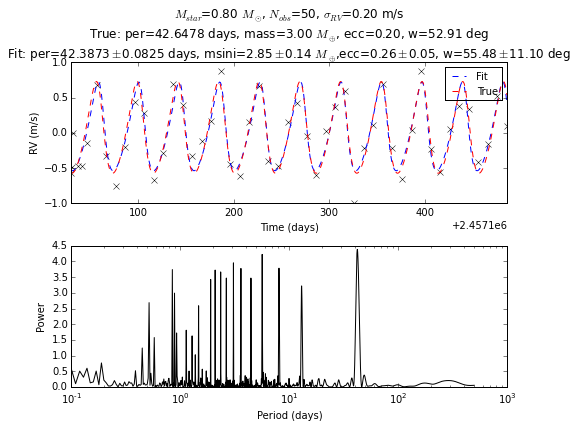

In [21]:
plt.close()
# sim1 = Simulator(50,0.05,massPlanet=5.,ecc=0.2,massStar=0.8,period=27.12453)
makePlot(sim1)
plt.close()

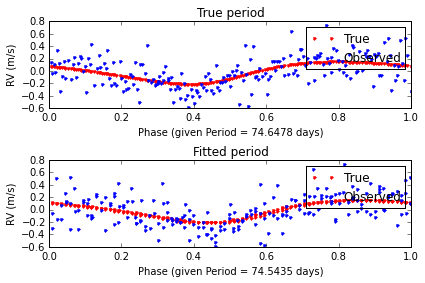

In [66]:
plt.close()
makePhasePlot(sim1)
plt.close()

In [ ]:
#Choose what to simulate
#pickle.dump



In [ ]:
#Choose what to plot
#pickle.load
